In [23]:
from pymongo import MongoClient
import os, re
from sklearn import linear_model
import numpy as np
import pandas as pd

MONGO_USER = os.environ['MONGO_USER']
MONGO_PASS = os.environ['MONGO_PASS']
MONGO_URL = os.environ['MONGO_URL']

%matplotlib inline

### Connecting to the database

In [2]:
uri = "mongodb://%s:%s@%s" % (
    MONGO_USER, MONGO_PASS, MONGO_URL)

client = MongoClient(uri)
db = client['HonoluluProperty']

### Finding the houses sold in 2010 - 2018

In [3]:
cursor = db['hnl_county_data'].find({'SalesInformation.0.saleDate': { '$regex': '.*201[0-8]' }})

houses2017 = list(cursor)

houses2017[0]

{'OwnerAndParcelInformation': {'OwnerName': 'WEBER,TEKLA S TR  Fee Owner',
  'ParcelNumber': '430040310000',
  'dataCurrentAsOf': 'January 30, 2018',
  'landArea(Acres)': '0.2513',
  'landArea(ApproximateSqFt)': '10,948',
  'legalInformationLOT11410,948SFMAP4LCAPP615TOG/R/O/WESMT': '',
  'locationAddress': '1407 AALAPAPA DR',
  'parcelMap': '',
  'platMap': '',
  'projectName': '',
  'propertyClass': 'RESIDENTIAL A'},
 'PermitInformation': [{'date': ' 03/16/1998 ',
   'permitAmount': ' $ 6,000 ',
   'permitNumber': '415064',
   'reason': ' '},
  {'date': ' 03/05/1993 ',
   'permitAmount': ' $ 125,000 ',
   'permitNumber': '332191',
   'reason': ' '},
  {'date': ' 01/11/1993 ',
   'permitAmount': ' $ 15,000 ',
   'permitNumber': '329726',
   'reason': ' '},
  {'date': ' 10/30/1991 ',
   'permitAmount': ' $ 18,000 ',
   'permitNumber': '309529',
   'reason': ' '}],
 'SalesInformation': [{'book/Page': ' ',
   'cert#': '333026 ',
   'dateOfRecording': '10/11/2010 ',
   'instrument#': ' ',


In [63]:
def assessmentInfo(house, saleYear):
    if not 'assessmentInformation' in house:
        return np.nan
    for info in house['assessmentInformation']:
        if int(info['assessmentYear'].strip()[-4:]) < int(saleYear[1:]):
            return info['totalPropertyAssessedValue']
        
def normalizePrice(priceString):
    return int(priceString[2:].strip().replace(',', ''))

def saleInfoExtraction(house):
    for sale in house['SalesInformation']:
        if sale['saleAmount']:
            return int(sale['saleDate'].strip()[-4:]), normalizePrice(sale['saleAmount'])
        
    return np.nan, np.nan

def featureExtraction(house):
    tmk = int(house['tmk'])
    if 'OwnerAndParcelInformation' in house:
        propertyClass = house['OwnerAndParcelInformation']['propertyClass']
        landArea = house['OwnerAndParcelInformation']['landArea(ApproximateSqFt)'] if 'landArea(ApproximateSqFt)' in house['OwnerAndParcelInformation'] else 0
        # assessmentInfo(house, saleInfoExtraction(house)[0]),
    else:
        propertyClass = 0
        landArea = 0
    
    if 'assessmentInformation' in house:
        numAssessments = len(house['assessmentInformation'])    
    else:
        numAssessments = 0
        
    if 'landInformation' in house and len(house['landInformation']) > 0:
        footage = house['landInformation'][0]['squareFootage']
        rebuilds = len(house['landInformation'])
    else:
        footage = 0
        rebuilds = 0
    
    if 'residentialImprovementInformation' in house and len(house['residentialImprovementInformation']) > 0:
        numBuildings = len(house['residentialImprovementInformation'])
        occupancy = house['residentialImprovementInformation'][0]['occupancy']
        houseArea = house['residentialImprovementInformation'][0]['squareFeet']
        yearBuilt = house['residentialImprovementInformation'][0]['yearBuilt']
        bedrooms = house['residentialImprovementInformation'][0]['bedrooms']
        baths = house['residentialImprovementInformation'][0]['fullBaths']
        halfBaths = house['residentialImprovementInformation'][0]['halfBaths']
    else:
        numBuildings = 0
        occupancy = 0
        houseArea = 0
        yearBuilt = 0
        bedrooms = 0
        baths = 0
        halfBaths = 0
    
    numPermits = len(house['PermitInformation']) if 'PermitInformation' in house else 0
    numSales = len(house['SalesInformation']) if 'SalesInformation' in house else 0
    
    return [tmk,
            propertyClass,
            landArea,
            numAssessments,
            footage,
            rebuilds,
            numBuildings,
            occupancy,
            houseArea,
            yearBuilt,
            bedrooms,
            baths,
            halfBaths,
            numPermits,
            numSales]


def digitsOnly(s):
    return all(c in '0123456789' for c in s)

def numericFeatureProcessing(feature):
    
    if type(feature) is int:
        return feature
    
    feature = feature.replace(',', '').strip()
    
    if not feature or not digitsOnly(feature):
        return 0
    else:
        return int(feature)
    
def stringFeatureProcessing(feature):
    if type(feature) is str:
        feature = feature.strip()
        if len(feature) > 3:
            return feature[:3]
        else:
            return feature
    else:
        return feature
    
def featureSetProcessing(features):
    for i in [2,4,8,9,10,11,12,13]:
        features[i] = numericFeatureProcessing(features[i])
    
    for i in [1,7]:
        features[i] = stringFeatureProcessing(features[i])
        
    return features

In [64]:
labels = [saleInfoExtraction(house) for house in houses2017]
features = [featureExtraction(house) for house in houses2017]
features = [featureSetProcessing(house) for house in features]
print(labels[:10], features[:10])

[(1989, 550000), (2013, 583000), (2010, 1000), (1989, 550000), (2012, 638000), (nan, nan), (nan, nan), (nan, nan), (nan, nan), (1995, 1330000)] [[430040310000, 'RES', 10948, 18, 10948, 1, 2, 'SIN', 1776, 1955, 4, 2, 1, 4, 4], [910920030000, 'RES', 4147, 19, 4147, 1, 1, 'SIN', 1530, 1995, 3, 2, 1, 1, 8], [941060560000, 'RES', 4009, 18, 4009, 1, 1, 'SIN', 1072, 1980, 3, 2, 0, 0, 12], [430040310000, 'RES', 10948, 18, 10948, 1, 2, 'SIN', 1776, 1955, 4, 2, 1, 4, 4], [970800130000, 'RES', 5605, 18, 5605, 1, 1, 'SIN', 2436, 1969, 5, 3, 0, 4, 9], [450720290000, 'RES', 6198, 18, 6198, 1, 1, 'SIN', 920, 1962, 2, 1, 0, 1, 2], [450720290000, 'RES', 6198, 18, 6198, 1, 1, 'SIN', 920, 1962, 2, 1, 0, 1, 2], [450720290000, 'RES', 6198, 18, 6198, 1, 1, 'SIN', 920, 1962, 2, 1, 0, 1, 2], [220120190000, 'RES', 3838, 18, 3500, 3, 1, 'SIN', 1700, 1948, 5, 2, 0, 0, 1], [240230370000, 'RES', 12000, 18, 12000, 1, 0, 0, 0, 0, 0, 0, 0, 0, 8]]


In [39]:
feeValues = pd.DataFrame([x[1] for x in labels])

In [40]:
feeValues.dropna(inplace = True)
feeValues = feeValues[feeValues > 1100]

In [41]:
feeValues = feeValues.apply(np.log)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b4fe069b0>]],
      dtype=object)

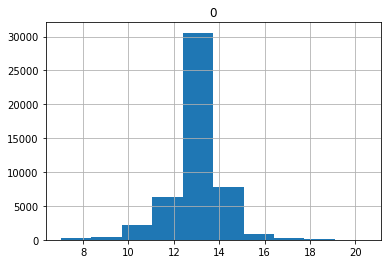

In [42]:
feeValues.hist()

In [69]:
df = pd.concat([pd.DataFrame(features), pd.DataFrame(labels, columns = ['saleYear', 'salePrice'])], axis = 1)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,saleYear,salePrice
0,430040310000,RES,10948,18,10948,1,2,SIN,1776,1955,4,2,1,4,4,1989.0,550000.0
1,910920030000,RES,4147,19,4147,1,1,SIN,1530,1995,3,2,1,1,8,2013.0,583000.0
2,941060560000,RES,4009,18,4009,1,1,SIN,1072,1980,3,2,0,0,12,2010.0,1000.0
3,430040310000,RES,10948,18,10948,1,2,SIN,1776,1955,4,2,1,4,4,1989.0,550000.0
4,970800130000,RES,5605,18,5605,1,1,SIN,2436,1969,5,3,0,4,9,2012.0,638000.0
5,450720290000,RES,6198,18,6198,1,1,SIN,920,1962,2,1,0,1,2,NaN,NaN
6,450720290000,RES,6198,18,6198,1,1,SIN,920,1962,2,1,0,1,2,NaN,NaN
7,450720290000,RES,6198,18,6198,1,1,SIN,920,1962,2,1,0,1,2,NaN,NaN
8,220120190000,RES,3838,18,3500,3,1,SIN,1700,1948,5,2,0,0,1,NaN,NaN
9,240230370000,RES,12000,18,12000,1,0,0,0,0,0,0,0,0,8,1995.0,1330000.0


In [71]:
df.rename({0: 'tmk', 1: 'propertyClass',
            2: 'landArea',
            3: 'numAssessments',
            4: 'footage',
            5: 'rebuilds',
            6: 'numBuildings',
            7: 'occupancy',
            8: 'houseArea',
            9: 'yearBuilt',
            10: 'bedrooms',
            11: 'baths',
            12: 'halfBaths',
            13: 'numPermits',
            14: 'numSales'}, axis = 'columns', inplace = True)


52082

In [81]:
df = df.dropna()[df.saleYear > 2009][df.salePrice > 2020][df.occupancy != 0]
len(df)

26296

In [82]:
df.head(10)

,tmk,propertyClass,landArea,numAssessments,footage,rebuilds,numBuildings,occupancy,houseArea,yearBuilt,bedrooms,baths,halfBaths,numPermits,numSales,saleYear,salePrice
1,910920030000,RES,4147,19,4147,1,1,SIN,1530,1995,3,2,1,1,8,2013.0,583000.0
4,970800130000,RES,5605,18,5605,1,1,SIN,2436,1969,5,3,0,4,9,2012.0,638000.0
11,910580400000,RES,3120,18,3120,1,1,SIN,1497,1990,4,2,1,0,8,2010.0,390000.0
16,290080410000,RES,17020,18,15520,2,1,SIN,3002,2006,5,3,1,8,11,2013.0,2425000.0
23,340300090000,RES,5345,18,5345,1,1,SIN,840,1954,4,1,0,0,5,2012.0,100000.0
27,340290040000,RES,5305,18,5305,1,1,SIN,836,1955,3,1,0,0,7,2016.0,731000.0
31,110710340000,RES,5507,18,5507,1,1,SIN,1180,1978,3,2,0,0,7,2015.0,651000.0
33,911661040000,RES,5476,3,5476,1,1,SIN,2295,2015,4,3,0,2,3,2015.0,791758.0
34,911380640000,RES,6980,12,6980,1,1,SIN,2196,2006,5,3,0,1,8,2014.0,599999.0
35,911660830000,RES,4582,3,4582,1,1,SIN,1796,2015,3,2,1,2,3,2015.0,641945.0


In [86]:
df.propertyClass.unique()

array(['RES', 'Mul', 'AGR', 'COM', 'IND', 'PRE'], dtype=object)

In [93]:
df = df[df.propertyClass == 'RES']
len(df)

25919

In [94]:
df.drop(labels = 'propertyClass', axis = 1, inplace = True)
len(df)

25919

In [104]:
df.occupancy = pd.factorize(df.occupancy)[0]

In [96]:
df['logPrice'] = np.log(df.salePrice * np.exp(2018 - df.saleYear))
df.head(10)

,tmk,landArea,numAssessments,footage,rebuilds,numBuildings,occupancy,houseArea,yearBuilt,bedrooms,baths,halfBaths,numPermits,numSales,saleYear,salePrice,logPrice
1,910920030000,4147,19,4147,1,1,SIN,1530,1995,3,2,1,1,8,2013.0,583000.0,18.275942
4,970800130000,5605,18,5605,1,1,SIN,2436,1969,5,3,0,4,9,2012.0,638000.0,19.366094
11,910580400000,3120,18,3120,1,1,SIN,1497,1990,4,2,1,0,8,2010.0,390000.0,20.873902
16,290080410000,17020,18,15520,2,1,SIN,3002,2006,5,3,1,8,11,2013.0,2425000.0,19.701342
23,340300090000,5345,18,5345,1,1,SIN,840,1954,4,1,0,0,5,2012.0,100000.0,17.512925
27,340290040000,5305,18,5305,1,1,SIN,836,1955,3,1,0,0,7,2016.0,731000.0,15.502169
31,110710340000,5507,18,5507,1,1,SIN,1180,1978,3,2,0,0,7,2015.0,651000.0,16.386265
33,911661040000,5476,3,5476,1,1,SIN,2295,2015,4,3,0,2,3,2015.0,791758.0,16.582011
34,911380640000,6980,12,6980,1,1,SIN,2196,2006,5,3,0,1,8,2014.0,599999.0,17.304683
35,911660830000,4582,3,4582,1,1,SIN,1796,2015,3,2,1,2,3,2015.0,641945.0,16.372258


In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
lm = LinearRegression()
svm = LinearSVR()

trainX = df.drop(columns = ['salePrice', 'logPrice'])
trainY = df.logPrice

In [110]:
print('Random Forest: ' + str(cross_val_score(rf, trainX, trainY, scoring = 'neg_mean_absolute_error')))

Random Forest: [-0.28513949 -0.28384368 -0.29230141]


In [111]:
print('Linear Regresion: ' + str(cross_val_score(lm, trainX, trainY, scoring = 'neg_mean_absolute_error')))

Linear Regresion: [-0.33030419 -0.32397205 -0.33971259]


In [112]:
print('Decision Tree: ' + str(cross_val_score(dt, trainX, trainY, scoring = 'neg_mean_absolute_error')))

Decision Tree: [-0.36605731 -0.37001325 -0.37565483]


In [113]:
print('SVM: ' + str(cross_val_score(svm, trainX, trainY, scoring = 'neg_mean_absolute_error')))

SVM: [-17.57239724 -17.57497123 -17.5605212 ]


In [119]:
df.to_csv('houses_processed.csv')

1.3498588075760032